# Stock Price Prediction Using Unscented Kalman Filter

In [66]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [67]:
import numpy as np
import pandas as pd

#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.stattools import acf, pacf, q_stat, adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [68]:
import platform
print(f"Python version: {platform.python_version()}")
print(f"numpy version: {np.__version__}")
print(f"panda version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")
import matplotlib
print(f"matplotlib version: {matplotlib.__version__}")
import statsmodels
print(f"statsmodel version: {statsmodels.__version__}")
import scipy
print(f"scipy version: {scipy.__version__}")
import sklearn 
print(f"sklearn version: {sklearn. __version__}")


Python version: 3.10.14
numpy version: 1.26.4
panda version: 2.2.1
seaborn version: 0.13.2
matplotlib version: 3.7.5
statsmodel version: 0.14.1
scipy version: 1.14.1
sklearn version: 1.4.1.post1


## Helper Function

In [69]:
# Helper Function to fetch historical stock data
import yfinance as yf
def get_stock_data(ticker, start_date, end_date):
    try:
        # https://medium.com/nerd-for-tech/all-you-need-to-know-about-yfinance-yahoo-finance-library-fa4c6e48f08e
        #data = yf.Ticker(ticker).history(start=start_date, end=end_date)  
        data = yf.download(ticker, start=start_date, end=end_date)
        return data
    except Exception as e:
        return f"Error fetching data: {e}"

In [70]:
# code from https://goldinlocks.github.io/Multivariate-time-series-models/

from scipy.stats import probplot, moment
# Hurst Exponent
def hurst(ts):
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0
    
# Correlogram Plot
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Gather Historical Data

In [71]:
ticker_symbol = "AAPL"  #  Apple Inc. 
start_date = "2020-01-01"
end_date = "2024-10-01"
stock_data = get_stock_data(ticker_symbol, start_date, end_date)
stock_data.asfreq('B').index  # set index frequency to business daliy
stock_data.info()

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1194 entries, 2020-01-02 to 2024-09-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1194 non-null   float64
 1   High       1194 non-null   float64
 2   Low        1194 non-null   float64
 3   Close      1194 non-null   float64
 4   Adj Close  1194 non-null   float64
 5   Volume     1194 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 97.6 KB


In [72]:
stock_data.isnull().sum(axis=0) # check any NA

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [73]:
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-24,228.649994,229.350006,225.729996,227.369995,227.369995,43556100
2024-09-25,224.929993,227.289993,224.020004,226.369995,226.369995,42308700
2024-09-26,227.300003,228.500000,225.410004,227.520004,227.520004,36636700
2024-09-27,228.460007,229.520004,227.300003,227.789993,227.789993,34026000
2024-09-30,230.039993,233.000000,229.649994,233.000000,233.000000,54541900


## Exploratory Data Analysis (EDA)

In [74]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1194.000000,1194.000000,1194.000000,1194.000000,1194.000000,1.194000e+03
mean,149.605151,151.293197,148.031840,149.736675,148.046880,9.308342e+07
std,37.871171,38.039523,37.684314,37.873764,38.404745,5.337046e+07
min,57.020000,57.125000,53.152500,56.092499,54.569729,2.404830e+07
25%,127.820000,129.210003,126.237499,127.534998,125.143400,5.797525e+07
50%,150.125000,151.709999,148.644997,150.634995,148.755249,7.845300e+07
75%,174.887505,176.644997,173.424999,175.057499,173.262184,1.095208e+08
max,236.479996,237.229996,233.089996,234.820007,234.548523,4.265100e+08


In [75]:
import plotly.express as px

fig = px.line(stock_data, x=stock_data.index, y='Close', title=f'The Stock Close Price of {ticker_symbol}',
              labels={'Close': 'Close Price $'},
              template='plotly', width=1000, height=600)
fig.update_traces(line_color='lawngreen')
fig.update_layout(title_font_color='blue', title_font_size=20)
fig.show()

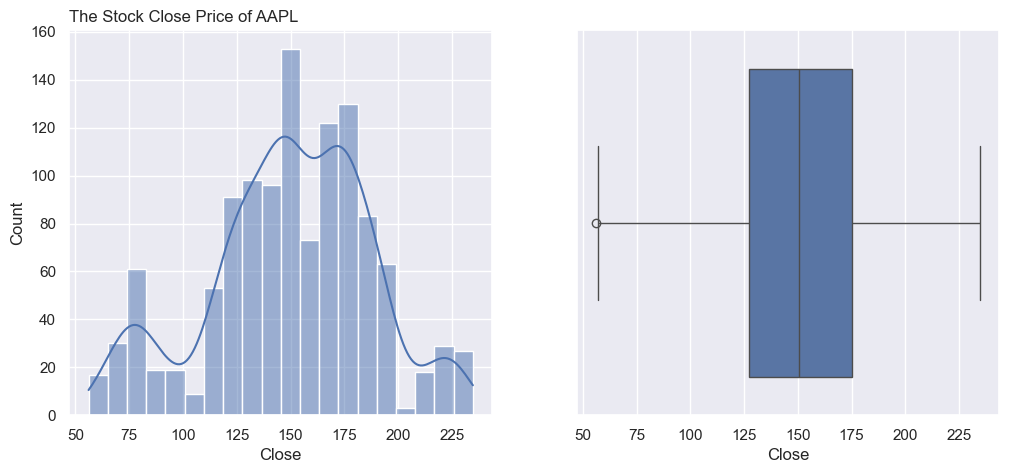

In [76]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title(f'The Stock Close Price of {ticker_symbol}', loc='left')
sns.histplot(stock_data['Close'], kde=True)
plt.subplot(1,2,2)
sns.boxplot(stock_data['Close'] , orient="h")
plt.show()


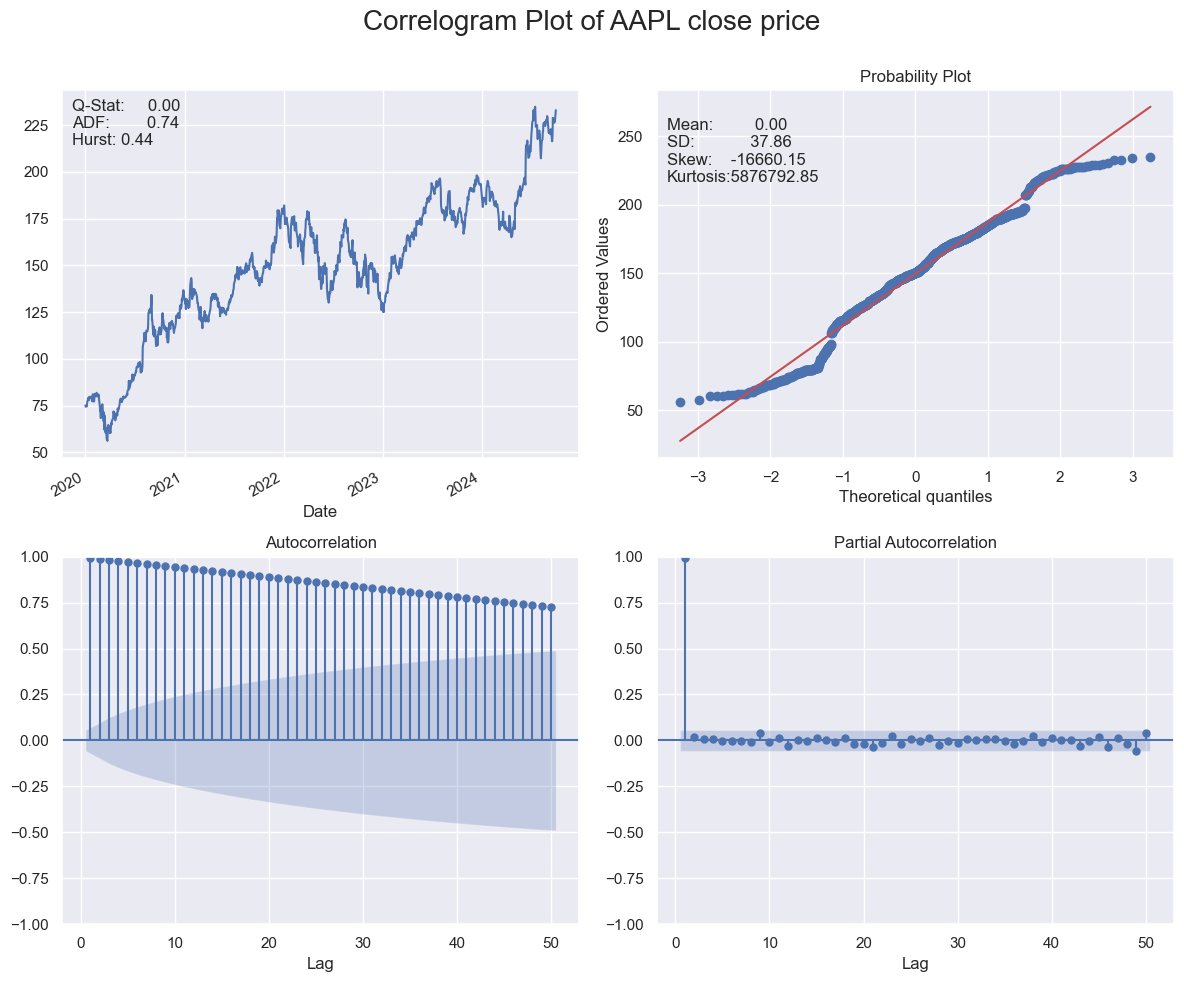

In [77]:
plot_correlogram(stock_data['Close'], lags=50, title=f'Correlogram Plot of {ticker_symbol} close price')

## Test for Stationarity

In [78]:
# Augmented Dickey–Fuller test for stationarity
result = adfuller(stock_data['Close'],regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] <= 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')

ADF Statistic: -2.533850
p-value: 0.549933
Critical Values:
	1%: -4.381
	5%: -3.837
	10%: -3.556
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


## Test for Normality

In [79]:
# code from https://dataaspirant.com/jarque-bera-test/

from scipy.stats import jarque_bera

# calculate the test statistic and p-value
jb_stat, jb_p = jarque_bera(stock_data['Close'])

# print the results
print("Jarque-Bera statistic:", jb_stat)
print("p-value:", jb_p)

# interpret the results
if jb_p < 0.05:
    print("The dataset is not normally distributed.")
else:
    print("The dataset is normally distributed.")

Jarque-Bera statistic: 19.72321958680977
p-value: 5.213835011076196e-05
The dataset is not normally distributed.


## Test for Autocorrelation

In [80]:
import pandas as pd
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox

def ljung_box_test_original(data, lags_list=[10, 15]):
    # Perform the Ljung-Box test for both lag=5 and lag=10
    for lag in lags_list:
        lb_test = acorr_ljungbox(data, lags=lags_list, return_df=True)

        # Extract p-value
        p_value = lb_test['lb_pvalue'].iloc[0]

        # Interpret the result
        if p_value > 0.05:
            interpretation = f"Fail to reject the null hypothesis at lag {lag}: No significant autocorrelation."
        else:
            interpretation = f"Reject the null hypothesis at lag {lag}: Significant autocorrelation present."

        print(f"Ljung-Box test p-value for lag {lag}: {p_value:.5f}")
        print(f"Interpretation: {interpretation}")
        print

ljung_box_test_original(stock_data['Close'])


Ljung-Box test p-value for lag 10: 0.00000
Interpretation: Reject the null hypothesis at lag 10: Significant autocorrelation present.
Ljung-Box test p-value for lag 15: 0.00000
Interpretation: Reject the null hypothesis at lag 15: Significant autocorrelation present.


### When the Ljung-Box test indicates significant autocorrelation, it means that the data points in the series are not randomly distributed. Instead, past values significantly influence future values, suggesting a pattern or trend in the data.

### If a time series is non-stationary but shows significant autocorrelation, it indicates that while the data has trends or varying means over time (non-stationarity), there are also patterns where past values are influencing future values (autocorrelation).

### Non-stationary data often means that mean, variance, or other statistical properties change over time. This can result from trends, seasonality, or structural changes in the data. Autocorrelation in this context suggests these patterns are not purely random but have predictable influences over time.

## Test for Nonlinearity 

In [81]:
# Brock-Dechert-Scheinkman (BDS) test,

import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat

# Function to perform the BDS test
def bds_test(data, max_dim=10):
    results = []
    for m in range(2, max_dim + 1):
        transformed_data = lagmat(data, m, trim='both')
        residuals = np.diff(transformed_data, axis=1)
        test_result = sm.tsa.stattools.bds(residuals[:, -1])
        results.append(test_result)
    return results

# Print function for BDS test results
def print_bds_results(results):
    for i, result in enumerate(results):
        m = i + 2
        test_statistic, p_value, *_ = result
        print(f"Dimension m = {m}:")
        print(f"  Test Statistic: {test_statistic:.4f}")
        print(f"  p-value: {p_value:.4f}")
        if p_value < 0.05:
            print("  Result: Reject the null hypothesis (Nonlinear dependencies detected)")
        else:
            print("  Result: Fail to reject the null hypothesis (Likely linear or i.i.d.)")
        print("")

# Perform BDS test
bds_results = bds_test(stock_data['Close'])

# Print BDS test results
print_bds_results(bds_results)

Dimension m = 2:
  Test Statistic: 4.8947
  p-value: 0.0000
  Result: Reject the null hypothesis (Nonlinear dependencies detected)

Dimension m = 3:
  Test Statistic: 4.8956
  p-value: 0.0000
  Result: Reject the null hypothesis (Nonlinear dependencies detected)

Dimension m = 4:
  Test Statistic: 4.8963
  p-value: 0.0000
  Result: Reject the null hypothesis (Nonlinear dependencies detected)

Dimension m = 5:
  Test Statistic: 4.8783
  p-value: 0.0000
  Result: Reject the null hypothesis (Nonlinear dependencies detected)

Dimension m = 6:
  Test Statistic: 4.9113
  p-value: 0.0000
  Result: Reject the null hypothesis (Nonlinear dependencies detected)

Dimension m = 7:
  Test Statistic: 4.8516
  p-value: 0.0000
  Result: Reject the null hypothesis (Nonlinear dependencies detected)

Dimension m = 8:
  Test Statistic: 5.3702
  p-value: 0.0000
  Result: Reject the null hypothesis (Nonlinear dependencies detected)

Dimension m = 9:
  Test Statistic: 5.0579
  p-value: 0.0000
  Result: Reject

In [82]:
# https://filterpy.readthedocs.io/en/latest/index.html
# !pip install filterpy

In [83]:
import filterpy
filterpy.__version__

'1.4.5'

## Perform a grid search for optimal parameters

In [84]:
import yfinance as yf
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
from itertools import product
import time  
 
start_time = time.time()  

close_prices = stock_data['Close'].values

# UKF setup
dt = 1.0   # Assuming daily interval (or adjust as per your data frequency)
n_dim_state = 2  # price and velocity
n_dim_meas = 1  # only measuring price

# Grid search for best parameters
alpha_values = [0.001, 0.01, 0.05, 0.1]
beta_values = [1.0, 2.0, 3.0, 4.0] 
kappa_values = [0, 1, 1]    # [0, 1, 3-n] (where n is the state dimension)

P_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Q_values = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
R_values = [0.01, 0.1, 0.5, 1.0]

# Calculate velocity (price change)
#velocity = np.diff(close_prices)
#close_prices = close_prices[1:]  # Remove the first element to match velocity length

# Define state transition function
def fx(x, dt):
    # Simple model assuming constant velocity, x[0] is price, x[1] is price change rate
    return np.array([x[0] + x[1] * dt, x[1]])

# Define measurement function
def hx(x):
    return np.array([x[0]])  # We only measure the price for simplicity

# Grid search
best_r2 = -np.inf
best_params = None

# Grid search over all parameter combinations
for alpha, beta, kappa, P, Q, R in product(alpha_values, beta_values, kappa_values, P_values, Q_values, R_values):
    # Initialize sigma points and UKF with current parameter set
    sigma_points = MerweScaledSigmaPoints(n=n_dim_state, alpha=alpha, beta=beta, kappa=kappa)   
    ukf = UnscentedKalmanFilter(dim_x=n_dim_state, dim_z=n_dim_meas, fx=fx, hx=hx, dt=dt, points=sigma_points)

    # Set covariance matrices for current parameter set
    # an identity matrix scaled by a constant
    ukf.P = np.eye(n_dim_state) * P
    #ukf.Q = np.eye(n_dim_state) * Q
    ukf.Q = Q_discrete_white_noise(dim=n_dim_state, dt=dt, var=0.13) * Q   # var=0.13, I based on max-min range of daily return of close price
    ukf.R = np.eye(n_dim_meas) * R


    # Initialize state (assuming initial price is known and velocity is zero)
    ukf.x = np.array([close_prices[0], 0])

    # Run filter over data and collect predictions
    predictions = []
    for z in close_prices:
        ukf.predict() # Predicts the next state based on the model.
        ukf.update(z) # Updates the state estimate with the actual closing price.
        predictions.append(ukf.x[0])

    r2 = r2_score(close_prices, predictions)
    
    if r2 > best_r2:
        best_r2 = r2
        best_params = (alpha, beta, kappa, P, Q, R)

print(f"Best R-squared: {best_r2}")
print(f"Best parameters: alpha={best_params[0]}, beta={best_params[1]}, kappa={best_params[2]}, P={best_params[3]}, Q={best_params[4]}, R={best_params[5]}")

print("\n")
end_time = time.time()  
execution_time = end_time - start_time  
hours, remainder = divmod(execution_time, 3600)  
minutes, seconds = divmod(remainder, 60)  
  
print(f"Execution time for grid search: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")

Best R-squared: 0.9999931898957107
Best parameters: alpha=0.001, beta=1.0, kappa=1, P=2.0, Q=1.0, R=0.01


Execution time for grid search: 0 hours, 25 minutes, 7 seconds


  Metric     Train      Test
0    MAE  0.074478  0.073778
1    MSE  0.009758  0.009768
2   RMSE  0.098785  0.098833
3   MAPE  0.000574  0.000376
4     R2  0.999991  0.999976


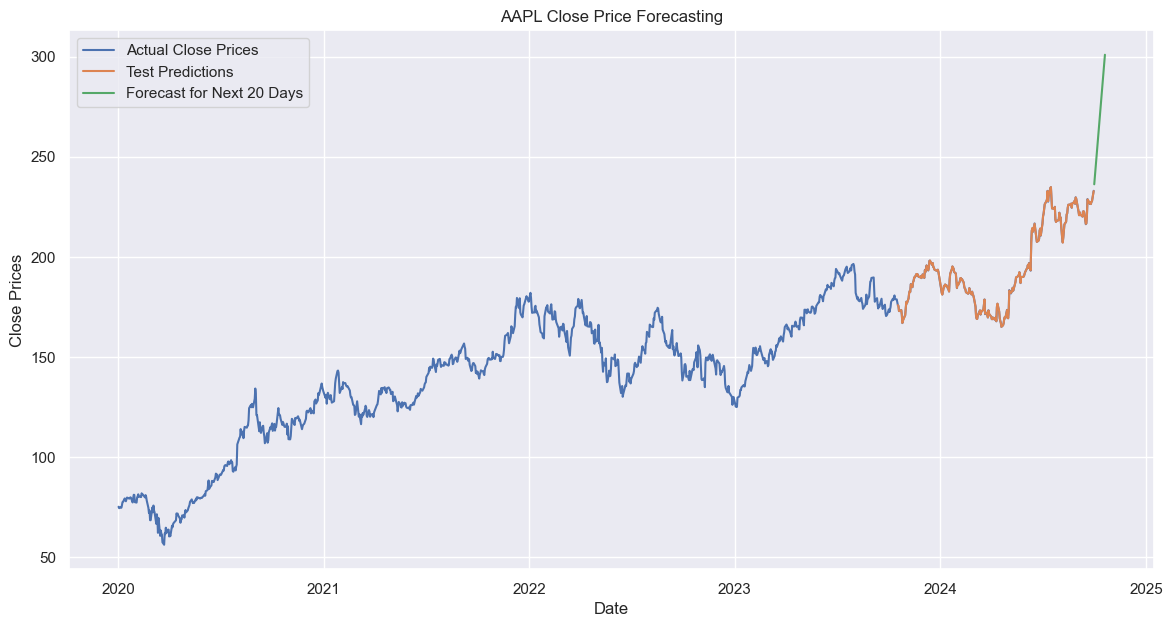

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise

# UKF setup
dt = 1.0   # Assuming daily interval (or adjust as per your data frequency)
n_dim_state = 2  # price and velocity
n_dim_meas = 1  # only measuring price

# Define the state transition function
def fx(x, dt):
    return np.array([x[0] + dt * x[1], x[1]])

# Define the measurement function
def hx(x):
    return np.array([x[0]])

# Load your data
close_prices = stock_data['Close'].values
#close_prices = close_prices[1:]

# Split the data into training and test sets
train_size = int(len(close_prices) * 0.8)
train_data, test_data = close_prices[:train_size], close_prices[train_size:]

# Assuming you have found the best parameters from the grid search
# Best parameters: alpha=0.001, beta=1.0, kappa=1, P=2.0, Q=1.0, R=0.01
best_params = {'alpha': 0.001, 'beta': 1.0, 'kappa': 1, 'P': 2.0, 'Q': 1.0, 'R': 0.01}

# Initialize the UKF with the best parameters
alpha, beta, kappa = best_params['alpha'], best_params['beta'], best_params['kappa']
P, Q, R = best_params['P'], best_params['Q'], best_params['R']

points = MerweScaledSigmaPoints(n=n_dim_state, alpha=alpha, beta=beta, kappa=kappa)
ukf = UnscentedKalmanFilter(dim_x=n_dim_state, dim_z=n_dim_meas, fx=fx, hx=hx, dt=dt, points=points)
ukf.P = np.eye(n_dim_state) * P
#ukf.Q = np.eye(n_dim_state) * Q
ukf.Q = Q_discrete_white_noise(dim=n_dim_state, dt=dt, var=0.13) * Q
ukf.R = np.eye(n_dim_meas) * R
ukf.x = np.array([train_data[0], 0])

# Fit the model to the training data
train_predictions = []
for z in train_data:
    ukf.predict()
    ukf.update(z)
    train_predictions.append(ukf.x[0])


# Evaluate the performance on the test set
test_predictions = []
for z in test_data:
    ukf.predict()
    ukf.update(z)
    test_predictions.append(ukf.x[0])


# Forecast the next n days
filtered_states = []
# Fit the model to the test data
for z in test_data:
    ukf.predict()
    ukf.update(z)
    filtered_states.append(ukf.x.copy())

n_forecast = 20
predictions = []
last_state = filtered_states[-1]
for _ in range(n_forecast):
    last_state = fx(last_state, dt)
    predictions.append(last_state[0])



# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index, close_prices, label='Actual Close Prices')
plt.plot(stock_data.index[-len(test_data):], test_predictions, label='Test Predictions')
plt.plot(pd.date_range(start=stock_data.index[-1], periods=n_forecast+1, inclusive='right'), predictions, label=f'Forecast for Next {n_forecast} Days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title(f'{ticker_symbol} Close Price Forecasting')
#plt.show()

# Save the figure
plt.savefig('UKF.jpg')


# Calculate error metrics
train_mae = mean_absolute_error(train_data, train_predictions)
train_mse = mean_squared_error(train_data, train_predictions)
train_rmse = np.sqrt(train_mse)
train_mape = mean_absolute_percentage_error(train_data, train_predictions)
train_r2 = r2_score(train_data, train_predictions)

test_mae = mean_absolute_error(test_data, test_predictions)
test_mse = mean_squared_error(test_data, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(test_data, test_predictions)
test_r2 = r2_score(test_data, test_predictions)



metric_data = {
    "Metric": ["MAE", "MSE", "RMSE", "MAPE", "R2"],
    "Train": [train_mae, train_mse, train_rmse, train_mape, train_r2],
    "Test": [test_mae, test_mse, test_rmse, test_mape, test_r2]
}

# Convert to dataframe
metric_df = pd.DataFrame(metric_data)

print(metric_df)

## Import pandas_market_calendars library, which provides market holidays for the US.

In [ ]:
#!pip install pandas_market_calendars

In [87]:
import pandas_market_calendars as mcal

business_days = 20

last_date = stock_data.index[-1]
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=business_days, freq='B')

# Get US holidays for the NYSE calendar 
nyse = mcal.get_calendar('NYSE') 
us_holidays = nyse.valid_days(start_date=prediction_dates[0], end_date=prediction_dates[-1])

# Filter out holidays 
filtered_dates = prediction_dates[~prediction_dates.isin(us_holidays)]

#print(filtered_dates)

predictions_df = pd.DataFrame(predictions, columns=['Predictions'], index=filtered_dates)
predictions_df

,Predictions
2024-10-01,236.262790
2024-10-02,239.671031
2024-10-03,243.079272
2024-10-04,246.487513
2024-10-07,249.895754
2024-10-08,253.303995
2024-10-09,256.712236
2024-10-10,260.120476
2024-10-11,263.528717
2024-10-14,266.936958


In [88]:

# Generate a date range excluding weekends
new_end_date = pd.date_range(start=end_date, periods=business_days, freq='B')[-1] + pd.Timedelta(days=1) # Add one day to include the end-date itself


# Fetch the stock data 
df = yf.download(ticker_symbol, start=end_date, end=new_end_date) 
# Extract the close prices 

new_close_prices = df['Close']

# Create a new DataFrame to concatenate the close prices
new_df = pd.DataFrame({'Close Prices': new_close_prices})

# Concatenate the new DataFrame with the original stock data
combined_df = pd.concat([new_df, predictions_df], axis=1)

print(combined_df)

[*********************100%%**********************]  1 of 1 completed

            Close Prices  Predictions
2024-10-01    226.210007   236.262790
2024-10-02    226.779999   239.671031
2024-10-03    225.669998   243.079272
2024-10-04    226.800003   246.487513
2024-10-07    221.690002   249.895754
2024-10-08    225.770004   253.303995
2024-10-09    229.539993   256.712236
2024-10-10    229.039993   260.120476
2024-10-11    227.550003   263.528717
2024-10-14    231.300003   266.936958
2024-10-15    233.850006   270.345199
2024-10-16    231.779999   273.753440
2024-10-17    232.149994   277.161681
2024-10-18    235.000000   280.569922
2024-10-21    236.479996   283.978162
2024-10-22    235.860001   287.386403
2024-10-23    230.759995   290.794644
2024-10-24    230.570007   294.202885
2024-10-25    231.410004   297.611126
2024-10-28    233.399994   301.019367
